In [1]:
#Utility
import urllib
import os
import datetime

#Data Science
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#Google API
import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage_v1beta2

## Mobility

In [2]:
#Import mobility from url
url = 'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'
mobility = pd.read_csv(url)

filterlist = ['retail_and_recreation_percent_change_from_baseline',
'grocery_and_pharmacy_percent_change_from_baseline',
'parks_percent_change_from_baseline',
'transit_stations_percent_change_from_baseline',
'workplaces_percent_change_from_baseline',
'residential_percent_change_from_baseline']

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Read usmobility into frame
usmobility = pd.read_csv('usmobility.csv')

## Cases from John Hopkins

In [9]:
#Import confirmed, deaths and recovered cases from url
confirmed = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
deaths = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")
recovered = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

In [10]:
#Formating confirmed as df ready for import for maindf
df = confirmed.copy()
xlist = ['UID', 'iso2', 'iso3', 'code3','Country_Region', 'Lat', 'Long_','Combined_Key']

df['Lookup'] = df['Admin2'] + df['Province_State']
includelist = [x for x in df.columns if x not in xlist]
datelist = includelist.copy()
datelist.pop(0)
datelist.pop(0)
datelist.remove('Lookup')
df = df.loc[:,includelist]

#Transpose and change index
lookuplist = df['Lookup'].to_list()
df = df.transpose()
df.columns = lookuplist
df = df.transpose()

In [11]:
#Formating deaths as df1 ready for import for maindf
df1 = deaths.copy()
xlist = ['UID', 'iso2', 'iso3', 'code3','Country_Region', 'Lat', 'Long_','Combined_Key']

df1['Lookup'] = df1['Admin2'] + df1['Province_State']
includelist = [x for x in df1.columns if x not in xlist]
datelist = includelist.copy()
datelist.pop(0)
datelist.pop(0)
datelist.pop(0)
datelist.pop(0)
datelist.remove('Lookup')
df1 = df1.loc[:,includelist]

#Transpose and change index
lookuplist = df1['Lookup'].to_list()
df1 = df1.transpose()
df1.columns = lookuplist
df1 = df1.transpose()

#Create a lookup list to loop over for maindf
lookuplist = df1['Lookup'].value_counts().index.to_list()
lookuplist = sorted(lookuplist)

## Contructing Main Dataframe

In [12]:
#Construction of maindf
colnames = ['Lookup','State','County','FIPS','Population','Date','Confirmed','Deaths']

maindf = pd.DataFrame(index=range(0,len(lookuplist)*len(datelist)), columns=colnames)

#Start loop for confirmed
j = 0
for i in lookuplist:
    testdf = df.loc[i,:]
    testdf1 = df1.loc[i,:]
    
    #Confirmed cases
    timeseries = testdf[3:-1]
    date = timeseries.index.to_list()
    timeseries = timeseries.to_list()
    length = len(timeseries)
    
    #Deaths
    timeseries1 = testdf1[4:-1].to_list()
    
    maindf.iloc[j:(j+length),colnames.index('Lookup')] = i
    maindf.iloc[j:(j+length),colnames.index('State')] = testdf[2]
    maindf.iloc[j:(j+length),colnames.index('County')] = testdf[1]
    maindf.iloc[j:(j+length),colnames.index('FIPS')] = testdf[0]
    maindf.iloc[j:(j+length),colnames.index('Population')] = testdf1[3]
    maindf.iloc[j:(j+length),colnames.index('Date')] = date
    maindf.iloc[j:(j+length),colnames.index('Confirmed')] = timeseries
    maindf.iloc[j:(j+length),colnames.index('Deaths')] = timeseries1
    j = j+length
    
maindf.loc[:,'Date1'] = pd.to_datetime(maindf['Date'],format='%m/%d/%y')
#test = maindf['Date1'].astype(str).tolist()
maindf['Lookup'] = maindf['Lookup'] + maindf['Date1'].astype(str).tolist()

labels = maindf['Lookup'].to_list()
maindf = maindf.transpose()
maindf.columns = labels
maindf = maindf.transpose()

In [50]:
#Merge maindf and mobility to finaldf
finaldf = maindf.merge(usmobility, left_on='Lookup', right_on='Lookup')
finaldf['StateCounty']=finaldf['State'] + finaldf['County']
finaldf['Confirmed'] = finaldf['Confirmed'].astype('int')
finaldf['Pct_Increase_Confirmed'] = finaldf['Confirmed'].pct_change()*100

In [54]:
def graph_county(FIPS):
    plt.clf()
    
    filterlist = ['retail_and_recreation_percent_change_from_baseline',
    'grocery_and_pharmacy_percent_change_from_baseline',
    'parks_percent_change_from_baseline',
    'transit_stations_percent_change_from_baseline',
    'workplaces_percent_change_from_baseline',
    'residential_percent_change_from_baseline']
    
    filterlist3 = filterlist.copy()
    filterlist3.extend(['Date1','Confirmed','Pct_Increase_Confirmed'])
    graphdf = finaldf[finaldf['FIPS']==FIPS].loc[:,filterlist3]

    index = graphdf['Confirmed'].index.to_list()[0]
    for i in graphdf['Confirmed']:
        index += 1
        if i != 0:
            break
    index -= 2
    #Get only days from the first case
    graphdf = graphdf.loc[index:,:]

    #Fill confirmed case increase rate
    lst = []
    j = 0
    for i in graphdf['Confirmed']:
        if i == 0:
            lst.append(0)
            j += 1
        elif i != 0:
            i = i/j
            lst.append(i)
            j += 1

    graphdf['Confirmed_Increase_Rate'] = lst
    
    #Graph
    ax = sns.lineplot(x='Date1',y='Confirmed_Increase_Rate',data=graphdf,label="Confirmed_Cases_Increase_Rate")
    ax.set(xlabel='Date', ylabel='Daily Cases')

    for ind, label in enumerate(ax.get_xticklabels()):
        if ind % 2 == 0:  # every nth label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)

    plt.title('Average Daily Cases since First Confirmed Cases')
    plt.legend(bbox_to_anchor=(1, 0), loc='lower left', ncol=1)

    displaymobility = graphdf.tail(1).loc[:,filterlist]
    displaymobility = displaymobility.transpose()
    displaymobility.columns = ['Value']
    displaymobility
    
    return(ax, displaymobility)

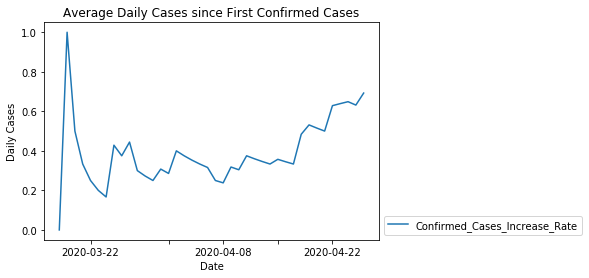

In [55]:
#Get graph for county --------------------------------------------------------
(countygraph, countymobility) = graph_county(45001)
countymobility
countygraph